In [1]:
from __future__ import print_function
import steps.model as smodel
import steps.solver as ssolver
import steps.geom as swm
import steps.rng as srng
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as itp
from tqdm import tqdm
from multiprocessing import Pool

from parameters import *
from misc import *
from components import *

### Loading vdcc_dat for given ISI

In [2]:
isi=20
loc="/home/kabir/Project/tripartiteSynapse/mcell"
VDCC_rates={
'VDCC_C01' : np.loadtxt(loc+"/vdcc_dat/VDCC_PQ_C01_" + str(isi) + "ms_ppf.dat"),
'VDCC_C12' : np.loadtxt(loc+"/vdcc_dat/VDCC_PQ_C12_" + str(isi) + "ms_ppf.dat"),
'VDCC_C23' : np.loadtxt(loc+"/vdcc_dat/VDCC_PQ_C23_" + str(isi) + "ms_ppf.dat"),
'VDCC_C3O' : np.loadtxt(loc+"/vdcc_dat/VDCC_PQ_C34_" + str(isi) + "ms_ppf.dat"),
'VDCC_OC3' : np.loadtxt(loc+"/vdcc_dat/VDCC_PQ_C43_" + str(isi) + "ms_ppf.dat"),
'VDCC_C32' : np.loadtxt(loc+"/vdcc_dat/VDCC_PQ_C32_" + str(isi) + "ms_ppf.dat"),
'VDCC_C21' : np.loadtxt(loc+"/vdcc_dat/VDCC_PQ_C21_" + str(isi) + "ms_ppf.dat"),
'VDCC_C10' : np.loadtxt(loc+"/vdcc_dat/VDCC_PQ_C10_" + str(isi) + "ms_ppf.dat"),
'VDCCflux'  : np.loadtxt(loc+"/vdcc_dat/VDCC_PQ_Ca_"  + str(isi) + "ms_ppf.dat")} 

#fitting cubic splines
VDCC_spline={}
for key in VDCC_rates.keys():
    VDCC_spline[key]=itp.interp1d(VDCC_rates[key].T[0],VDCC_rates[key].T[1],kind='previous',fill_value=(np.nan, VDCC_rates[key].T[1][-1]), bounds_error=False)

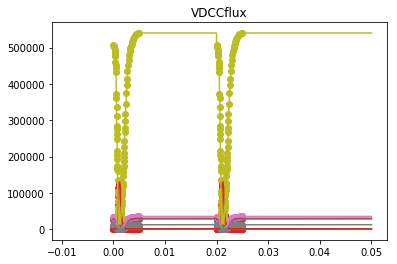

In [3]:
for key in VDCC_spline.keys():
    #plt.figure(figsize=(20,10))
    #VDCC_spline[key](0)
    plt.title(key)
    plt.scatter(VDCC_rates[key].T[0],VDCC_rates[key].T[1])
    x=np.linspace(0,0.050,10000)
    plt.plot(x,VDCC_spline[key](x))
    #float(itp.splev(1,VDCC_spline['VDCC_C3O'],der=0))

In [4]:
class model_part:
    def __init__(self,name,molnames,init,system,mdl,Ca,get_function,geom):
        self.name,self.molnames,self.init,self.system,self.mdl,self.Ca,self.get_function=name,molnames,init,system,mdl,Ca,get_function
        self.geom=geom
        self.mol_num=len(self.molnames)
        self.get_part()
        
        
    def get_part(self):
        self.Mol,self.R_part=self.get_function(self.system,self.mdl,self.Ca)
        
    def initialize(self,sim,npts):
        if str(self.system.__class__)=="<class 'steps.model.Surfsys'>":
            self.setCount=sim.setPatchCount
            self.getCount=sim.getPatchCount
        else:
            self.setCount=sim.setCompConc
            self.getCount=sim.getCompCount

        for mol,ic in zip(self.molnames,self.init):
            self.setCount(self.geom.getID(), mol, ic)
            #print(mol,ic)
            
        #self.result=np.zeros([npts,self.mol_num])
        
    def get_result(self,result,t,pos):
        for i,mol in enumerate(self.molnames):
            result[t,pos+i] = self.getCount(self.geom.getID(), mol)
            

In [5]:
mParts = [ 'cb', 'pmca', 'vdcc', 'az', 'serca', 'ryr']# , 
#mParts = ['cb']


mdl = smodel.Model()
cytvsys = smodel.Volsys('cytvsys', mdl)
cytssys = smodel.Surfsys('cytSurfsys', mdl)

ervsys = smodel.Volsys('ervsys', mdl)
erssys = smodel.Surfsys('erSurfsys', mdl)

Ca = smodel.Spec('Ca', mdl)

wmgeom = swm.Geom()

# Create the cytosol compartment
cytVol = swm.Comp('cytVol', wmgeom, vol=cytVolVal) # cyt vol = 1 - ER vol = 0.961 um^3
cytVol.addVolsys('cytvsys')

# cyt is the 'inner' compartment, no outer compartment
cytSurf = swm.Patch('cytSurf', wmgeom, cytVol, area=cytArea) # cyt surf area = 8.5 um^2
cytSurf.addSurfsys('cytSurfsys')

# Create the Endoplasmic Reticulum compartment
erVol = swm.Comp('erVol', wmgeom, vol=erVolVal) # ER vol = 0.039 um^3
erVol.addVolsys('ervsys')

# # ER is the 'inner' compartment, cyt is the 'outer' compartment
erSurf = swm.Patch('erSurf', wmgeom, erVol, cytVol, area=erArea) # ER surf area = 1.58 um^2
erSurf.addSurfsys('erSurfsys')

print('Inner compartment to cytSurf is', erSurf.getIComp().getID())
print('Outer compartment to cytSurf  is', erSurf.getOComp().getID())
"""
if 'cb'    in mParts: cbMol,    R_cb    = get_cb(cytvsys, mdl, Ca)
if 'pmca'  in mParts: pmcaMol,  R_PMCA  = get_PMCA(cytssys, mdl, Ca)
if 'vdcc'  in mParts: vdccMol,  R_VDCC  = get_VDCC(cytssys, mdl, Ca)
if 'az'    in mParts: azMol,    R_AZ    = get_AZ(cytssys, mdl, Ca)
if 'serca' in mParts: sercaMol, R_SERCA = get_SERCA(erssys, mdl, Ca)
if 'ryr'   in mParts: ryrMol,   R_RyR   = get_RyR(erssys, mdl, Ca)
#"""

MPs={}
if 'cb'    in mParts: MPs['cb']=model_part('cb',cbMolName,initV['cb'],cytvsys,mdl,Ca,get_cb,cytVol)
if 'pmca'  in mParts: MPs['pmca']=model_part('pmca',pmcaMolName,initV['PMCA'],cytssys,mdl,Ca,get_PMCA,cytSurf)
if 'vdcc'  in mParts: MPs['vdcc']=model_part('vdcc',vdccMolName,initV['VDCC'],cytssys,mdl,Ca,get_VDCC,cytSurf)
if 'az'    in mParts: MPs['az']=model_part('az',azMolName,initV['AZ'],cytssys,mdl,Ca,get_AZ,cytSurf)
if 'serca' in mParts: MPs['serca']=model_part('serca',sercaMolName,initV['serca'],erssys,mdl,Ca,get_SERCA,erSurf)
if 'ryr'   in mParts: MPs['ryr']=model_part('ryr',ryrMolName,initV['ryr'],erssys,mdl,Ca,get_RyR,erSurf)

Inner compartment to cytSurf is erVol
Outer compartment to cytSurf  is cytVol


In [6]:
### Simulation time
ti, tf, dt = 0, 50.0e-3, 1e-5
T = np.arange(ti, tf+dt, dt)
npts = len(T)

r = srng.create('mt19937', 256)
r.initialize(23411)

In [7]:
def simulation(seed):
    #print(r.get())
    print(seed)
    r.initialize(23411+seed)
    sim = ssolver.Wmdirect(mdl, wmgeom, r)

    sim.reset()

    ### Set initial conditions
    sim.setCompConc('cytVol', 'Ca', 1e-7) #initV['Ca'][0])
    sim.setCompConc('erVol', 'Ca', 250e-6)

    for p in mParts:
        MPs[p].initialize(sim,npts)


    ### result container
    result = np.zeros([npts,2+sum([MPs[p].mol_num for p in mParts])])

    #resCa = np.zeros([npts])
    #resCae = np.zeros([npts])

    #if 'cb'   in mParts: rescb   = np.zeros([npts, len(cbMolName)])
    #if 'pmca' in mParts: resPMCA = np.zeros([npts, len(pmcaMolName)])
    #if 'vdcc' in mParts: resVDCC = np.zeros([npts, len(vdccMolName)])
    #if 'az'   in mParts: resAZ   = np.zeros([npts, len(azMolName)])
    #if 'ryr'  in mParts: resRyR  = np.zeros([npts, len(ryrMolName)])
    #if 'serca'  in mParts: resSERCA  = np.zeros([npts, len(sercaMolName)])


    #Ti = time()
    for t in range(npts):
        ##Updating VDCC rates
        if 'vdcc' in mParts:
            for key in MPs['vdcc'].R_part.keys():
                sim.setPatchSReacK('cytSurf','R_'+key,float(VDCC_spline[key](T[t])))

        sim.run(T[t])
        
        pos=0
        result[t,pos] = sim.getCompCount('cytVol', 'Ca')
        pos+=1
        #resCa[t] = sim.getCompCount('cytVol', 'Ca')
        result[t,pos] = sim.getCompCount('erVol', 'Ca')
        pos+=1
        
        for p in mParts:
            MPs[p].get_result(result,t,pos)
            pos+=MPs[p].mol_num



    #Tf = time()
    #print(Tf-Ti, 'sec')
    
    return result

In [8]:
NITER = 10
res=[]

p=Pool(5)
res=p.map(simulation,range(NITER))


mean=np.average(np.stack(tuple(res)),axis=0)

2
0
3
1
4
5
6
7
8
9


In [9]:
mean.shape

(5001, 75)

## Plots

75


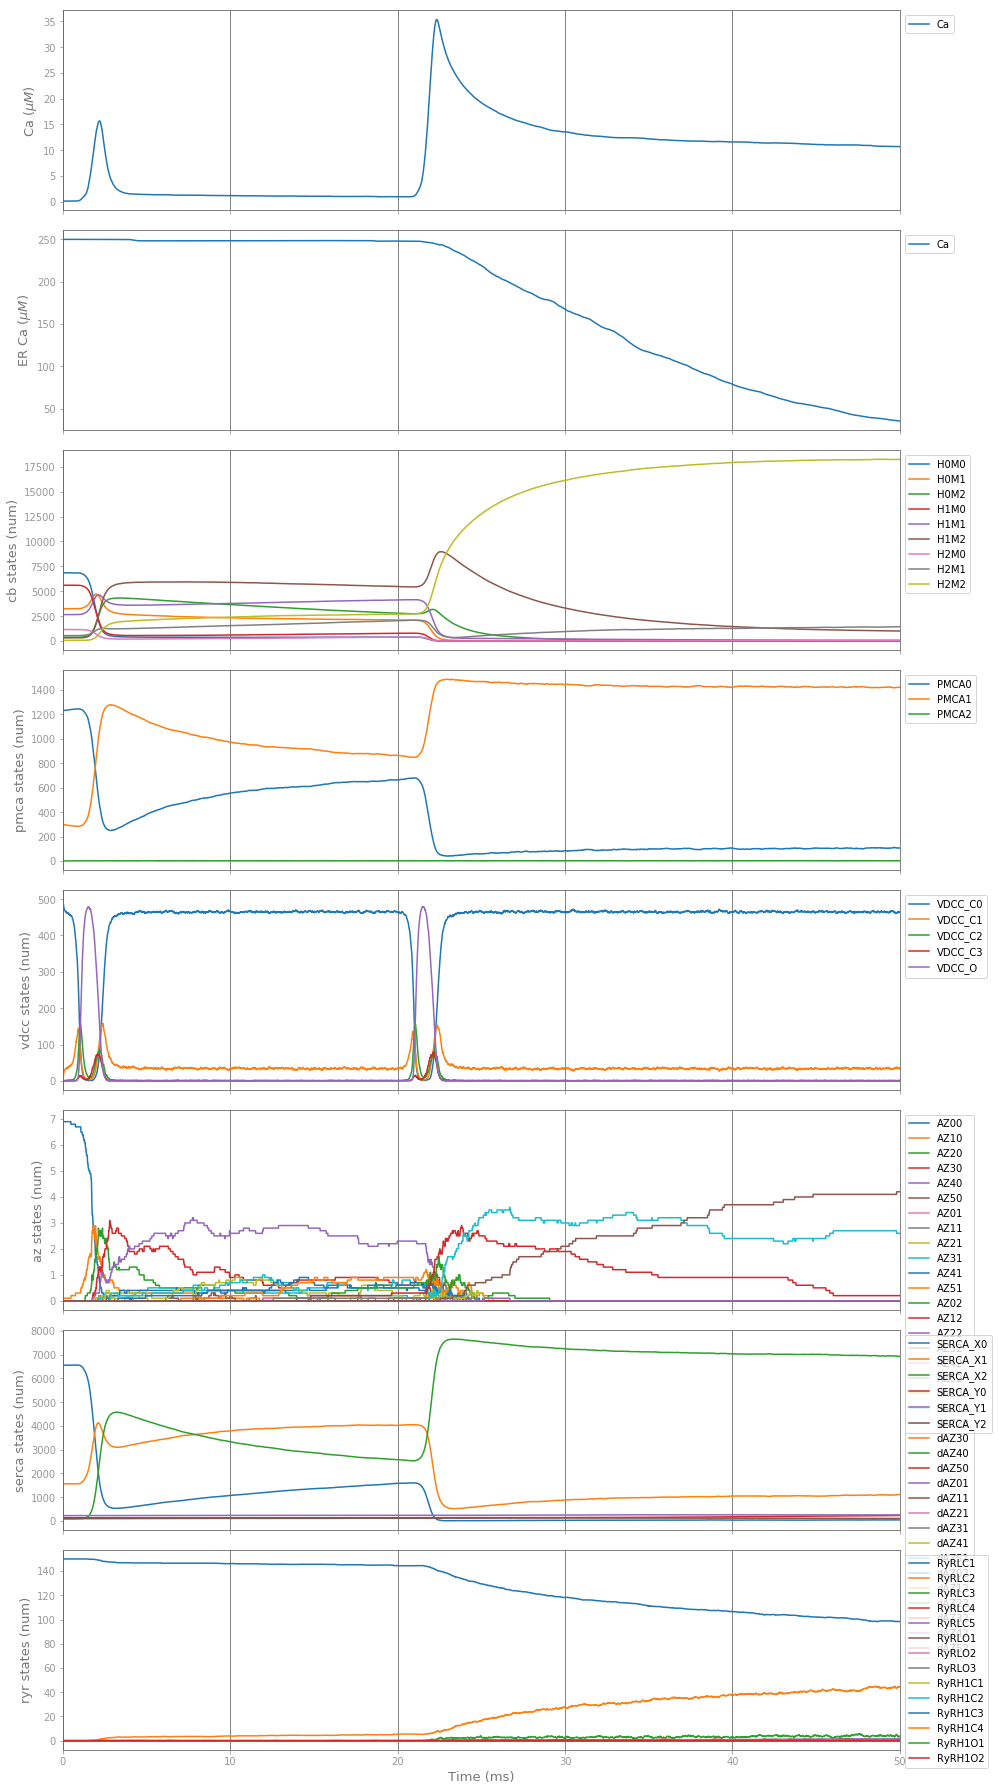

In [10]:
nFig = 2 + len(mParts)
figure, ax = plt.subplots(nFig, figsize=(15, 4*nFig), sharex=True)
figure.subplots_adjust(hspace=0.1)
labelfontsize = 13

t_millisec = T*1e3
j = 0
pos = 0
ax[j].plot(t_millisec, mean[:,pos]/NA/cytVolVal*1e3, label='Ca')
ax[j].set_ylabel(r'Ca ($\mu M$)', fontsize=labelfontsize)
j += 1
pos += 1

ax[j].plot(t_millisec, mean[:,pos]/NA/erVolVal*1e3, label='Ca')
ax[j].set_ylabel(r'ER Ca ($\mu M$)', fontsize=labelfontsize)
j += 1
pos += 1

for p in mParts:
    for i,mol in enumerate(MPs[p].molnames):
        ax[j].plot(t_millisec, mean[:,i+pos], label=mol)
    ax[j].set_ylabel(p+' states (num)', fontsize=labelfontsize)
    j += 1
    pos += MPs[p].mol_num
    #print(MPs[p].mol_num,MPs[p].molnames,pos)
print(pos)

ax[-1].set_xlabel('Time (ms)', fontsize=labelfontsize)

facecol = '#ffffff11'
labelcol = '#777777'
tickcol = '#999999'
spinecol = '#666666'
for x in ax:
    x.legend(loc='upper left', facecolor='white', framealpha=0.8, bbox_to_anchor=(1,1))
    
    x.set_xlim(min(t_millisec), max(t_millisec))
    
    x.spines['bottom'].set_color(spinecol)
    x.spines['top'].set_color(spinecol)
    x.spines['right'].set_color(spinecol)
    x.spines['left'].set_color(spinecol)
    
    x.xaxis.label.set_color(labelcol)
    x.yaxis.label.set_color(labelcol)
    
    x.tick_params(axis='x', colors=tickcol)
    x.tick_params(axis='y', colors=tickcol)
    
    x.set_facecolor(facecol)#'xkcd:salmon')
    
    x.grid(axis='x', color=spinecol)

#plt.savefig('test.pdf', dpi=300, format='pdf', transparent=True, bbox_inches=None, pad_inches=0.1)
#plt.show()

### ryr opening

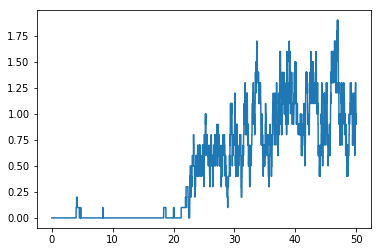

In [11]:
ss = np.sum(mean[:,[75-14+i for i in [5,6,7,12,13]]].T, axis=0)
plt.plot(t_millisec, ss)
#for i,mol in enumerate(MPs['ryr'].molnames):
#    plt.plot(t_millisec, mean[:,75-14:75], label=mol)
#ax[j].set_ylabel('RyR states (num)', fontsize=labelfontsize)
#    j += 1

In [12]:
#help(sim.getPatchSReacK)

In [13]:
sim = ssolver.Wmrk4(mdl, wmgeom, r)

In [14]:
help(sim.advance)

Help on method advance in module steps.solver:

advance(advance_time, cp_interval=0.0, prefix='') method of steps.solver.Wmrk4 instance
    Advance the simulation for advance_time,
    automatically checkpoint at each cp_interval.
    Prefix can be added using prefix=<prefix_string>.



help(sim)

a=np.array([1,2,3])
b=np.array([1,2,3])
c=np.array([1,2,3])
np.stack((a,b,c))


mdl = smodel.Model()
a = mdl

cytvsys = smodel.Volsys('cytvsys', mdl)

mdl
    

Ca = smodel.Spec('Ca', mdl)

c=Ca

Ca

c

wmgeom.getAllComps()[1].volsys



dir(wmgeomgetAllComps',
getAllPatches)

cytvsys.getID()

str(erssys.__class__)=="<class 'steps.model.Surfsys'>"

cytSurf.getID()

abc=np.array([1,2,3])
DEF=np.zeros(3)

DEF

[150]+[0]*13

[7] + [0 for _ in range(17)]

[int(8.5*180*i) for i in [0.80, 0.1953, 0.0047]]